# **Desafio Técnico Data Engineer III Localiza - Elcio Junior**


## **Sumário**
###**1 - Coleta e Limpeza de Dados**
####*1.1 - Verificação de duplicidade de dados*
####*1.2 - Verificação de nulos*
####*1.3 - Verificação de possíveis anomalias*
###**2 - Criação das tabelas-resultado**
####*2.1 - Listar em ordem decrescent "location_region" por média de "risk_score"*
####*2.2 - Listar os 3 "receiving address" com maior "amount" dentre a transação com "timestamp" mais recente e "transaction_type" = "sale" de cada "receiving_address"*
###**3 - Data Quality**
###**4 - Data Quality (Representação Gráfica)**
####*4.1 - Distribuição de Valores Nulos por Coluna*
####*4.2 - Percentual de Conformidade*
####*4.3 - Distribuição dos Valores em "amount"*
###**5 - Conteinerização**
###**6 - Orquestração**

## **1 - Coleta e Limpeza de Dados**


### Será utilizado o PySpark

O PySpark, construído sobre o Apache Spark, é uma poderosa biblioteca que proporciona a flexibilidade do Python juntamente com a capacidade de processamento distribuído do Spark. Essa combinação única permite que manipulemos e analisemos grandes volumes de dados de maneira escalável e eficiente.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=2f2e6e8a792490845ec16386e38bbf1c6a4a0c10ec0408f1f498de0f81391cad
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [52]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import Window

In [4]:
spark = SparkSession.builder.master('local[*]').appName("Desafio Técnico Data Engineer III Localiza - Elcio Junior").getOrCreate()

In [5]:
spark

In [6]:
fraud_credit = '/content/df_fraud_credit.csv'

In [11]:
df_fraud_credit = spark.read.csv(fraud_credit, sep=',', header=True, inferSchema=True)

In [16]:
df_fraud_credit.show()

+----------+--------------------+--------------------+-------+----------------+---------------+---------+---------------+----------------+----------------+-----------+----------+-------------+
| timestamp|     sending_address|   receiving_address| amount|transaction_type|location_region|ip_prefix|login_frequency|session_duration|purchase_pattern|  age_group|risk_score|      anomaly|
+----------+--------------------+--------------------+-------+----------------+---------------+---------+---------------+----------------+----------------+-----------+----------+-------------+
|1618185002|0x9d32d0bf2c00f41...|0x39f82e1c09bc6d7...|67435.0|        transfer|         Europe|    192.0|              3|              48|         focused|established|     18.75|     low_risk|
|1698642474|0xd6e251c23cbf52d...|0x51e8fbe24f124e0...|    1.0|        purchase|  South America|    172.0|              5|              61|         focused|established|      25.0|     low_risk|
|1619180066|0x2e0925b922fed01...|0x

In [17]:
df_fraud_credit.printSchema()

root
 |-- timestamp: integer (nullable = true)
 |-- sending_address: string (nullable = true)
 |-- receiving_address: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- location_region: string (nullable = true)
 |-- ip_prefix: double (nullable = true)
 |-- login_frequency: integer (nullable = true)
 |-- session_duration: integer (nullable = true)
 |-- purchase_pattern: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- risk_score: string (nullable = true)
 |-- anomaly: string (nullable = true)



#### 1.1 - Verificação de duplicidade de dados

In [20]:
# Qtd total de linhas
total_rows = df_fraud_credit.count()
total_rows

207359

In [21]:
# Qtd de linhas únicas
unique_rows = df_fraud_credit.dropDuplicates().count()
unique_rows

207359

In [22]:
# Verificação de dupliciade
if total_rows > unique_rows:
    print(f"Há {total_rows - unique_rows} linhas duplicadas.")
else:
    print("Não há linhas duplicadas.")


Não há linhas duplicadas.


#### 1.2 - Verificação de nulos

In [25]:
# Contar os valores nulos em cada coluna e imprimir a quantidade
null_counts = df_fraud_credit.select([f.sum(f.col(column).isNull().cast("int")).alias(column) for column in df_fraud_credit.columns])
null_counts.show()

# Verificar se há ou não valores nulos e printar o resultado
for column in df_fraud_credit.columns:
    null_count = null_counts.select(column).collect()[0][0]
    if null_count > 0:
        print(f"A coluna '{column}' contém {null_count} valores nulos.")
    else:
        print(f"A coluna '{column}' não contém valores nulos.")

+---------+---------------+-----------------+------+----------------+---------------+---------+---------------+----------------+----------------+---------+----------+-------+
|timestamp|sending_address|receiving_address|amount|transaction_type|location_region|ip_prefix|login_frequency|session_duration|purchase_pattern|age_group|risk_score|anomaly|
+---------+---------------+-----------------+------+----------------+---------------+---------+---------------+----------------+----------------+---------+----------+-------+
|        0|              0|                0|     0|               0|              0|        0|              0|               0|               0|        0|         0|      0|
+---------+---------------+-----------------+------+----------------+---------------+---------+---------------+----------------+----------------+---------+----------+-------+

A coluna 'timestamp' não contém valores nulos.
A coluna 'sending_address' não contém valores nulos.
A coluna 'receiving_addr

#### 1.3 - Verificação de possíveis anomalias

##### Para isso, foi feito um distinct em cada coluna, ordenando de forma crescente, para tentar entender o comportamento dos dados inseridos.

In [49]:
# Iterar sobre todas as colunas do DataFrame
for column in df_fraud_credit.columns:
    print(f"Distintos e ordenados para a coluna: {column}")

    # Realizar o distinct e ordenar para a coluna atual
    df_distinct = df_fraud_credit.select(column).distinct().orderBy(column)

    df_distinct.show(truncate=False)

Distintos e ordenados para a coluna: timestamp
+----------+
|timestamp |
+----------+
|1577837361|
|1577838583|
|1577839150|
|1577839432|
|1577839448|
|1577840396|
|1577840695|
|1577841354|
|1577841534|
|1577841739|
|1577842532|
|1577844157|
|1577844216|
|1577844278|
|1577844543|
|1577845601|
|1577845731|
|1577846480|
|1577846514|
|1577846898|
+----------+
only showing top 20 rows

Distintos e ordenados para a coluna: sending_address
+------------------------------------------+
|sending_address                           |
+------------------------------------------+
|0x00262fa3b21847775e2db42965d0192e8dfe5bdc|
|0x002bcd751410a69b3bce463890abb2fcab81a755|
|0x00318c7963a45ceb6b3101e1794ad42137da8f3f|
|0x003ebce509d14e6252dc14c35beb43d2dc52f35c|
|0x004fd71e61d0fb00f974635faec45195b8239607|
|0x006964d8bad07317bd17d20e084b94b7d9245db6|
|0x00e146b83342807fb6d5ada66b9559de1fcb7635|
|0x00f47be991d8e476be53b937a627a0a938355f98|
|0x015589d9f0bf74c5408f28c950738a210c093698|
|0x0216eabb3496a5f88b1

#### 1.3 - Tratando anomalias
* Verifiquei que a coluna "location_region" possui um valor fora dos padrões e para melhorar a clareza na visualização decidi substituir o valor "0" por "Não Identificado".

* Além disso, foi verificado em um dos primeiros passos que a coluna "amount" está com o data type = "string", tendo em vista que é uma unidade de quantia será transformada para "int".

In [56]:
# Substituir "0" por "Não identificado" na coluna location_region
df_fraud_credit = df_fraud_credit.withColumn("location_region", f.when(df_fraud_credit["location_region"] == "0", "Não identificado").otherwise(df_fraud_credit["location_region"]))

df_fraud_credit = df_fraud_credit.withColumn("amount", f.col("amount").cast("int"))


## **2 - Criação das tabelas-resultado**

#### 2.1 - Listar em ordem decrescent "location_region" por média de "risk_score"

In [57]:
# Calcula a média de 'risk score' por 'location_region' e ordena em ordem decrescente
df_location = df_fraud_credit.groupBy("location_region") \
                .agg(f.avg("risk_score").alias("average_risk_score")) \
                .orderBy(f.col("average_risk_score").desc())

# Mostrar o resultado
df_location.show()

+----------------+------------------+
| location_region|average_risk_score|
+----------------+------------------+
|   South America| 45.17340290646643|
|   North America| 45.15432162201378|
|            Asia|45.022036443610475|
|          Africa| 44.87021649763689|
|          Europe| 44.61330514857742|
|Não identificado| 44.58949718045112|
+----------------+------------------+



#### 2.1 - Listar os 3 "receiving address" com maior "amount" dentre a transação com "timestamp" mais recente e "transaction_type" = "sale" de cada "receiving_address"

In [58]:
# Filtrar transações do tipo 'sale'
df_sales = df_fraud_credit.filter(df_fraud_credit.transaction_type == "sale")

# Criar uma janela para identificar a transação mais recente por 'receiving_address'
window_spec = Window.partitionBy("receiving_address").orderBy(f.col("timestamp").desc())

# Adicionar uma coluna com a ordem das transações
df_sales_recent = df_sales.withColumn("row_number", f.row_number().over(window_spec))

# Filtrar apenas a transação mais recente por 'receiving_address'
df_sales_recent = df_sales_recent.filter(f.col("row_number") == 1)

# Selecionar os 3 'receiving_address' com maior 'amount'
df_top3 = df_sales_recent.orderBy(f.col("amount").desc()).limit(3)

df_top3.show()


+----------+--------------------+--------------------+------+----------------+---------------+---------+---------------+----------------+----------------+---------+----------+-------------+----------+
| timestamp|     sending_address|   receiving_address|amount|transaction_type|location_region|ip_prefix|login_frequency|session_duration|purchase_pattern|age_group|risk_score|      anomaly|row_number|
+----------+--------------------+--------------------+------+----------------+---------------+---------+---------------+----------------+----------------+---------+----------+-------------+----------+
|1702429736|0xb10f08393f28f97...|0xfe2650f030f2c96...| 76757|            sale|         Africa|     10.0|              2|              20|          random|      new|      50.0|     low_risk|         1|
|1698313051|0xc425ff34632d4bc...|0xc650a36cc875e16...| 76704|            sale|         Europe|    192.0|              2|              26|          random|      new|      50.0|     low_risk|       

## **3 - Data Quality**

* Contagem de Nulos
* Detecção de Nulos
* Detecção de Valores Inconsistentes ou Incorretos
* Cálculo do Percentual de Conformidade

In [72]:

# Coletar o total de erros (valores nulos) em uma lista
total_erros_list = null_counts.select([f.sum(f.col(c)).alias(c) for c in null_counts.columns]).collect()

# Printar o resultado coletado para verificar os valores
print("Resultado coletado do DataFrame:")
for row in total_erros_list:
    print(row.asDict())  # Mostrar todos os valores da Row como um dicionário

# Extrair o primeiro (e único) Row e converter os valores para inteiros
total_erros_dict = total_erros_list[0].asDict()

# Corrigir a soma dos valores nulos
total_erros = 0
for value in total_erros_dict.values():
    try:
        total_erros += int(value)
    except ValueError:
        print(f"Não foi possível converter o valor para inteiro: {value}")

print(f"Total de erros: {total_erros}")

# Verificar a quantidade total de registros
total_registros = df_fraud_credit.count()
print(f"Quantidade total de registros: {total_registros}")

# Calcular o percentual de conformidade
percentual_conformidade = ((total_registros - total_erros) / total_registros) * 100
print(f"Percentual de conformidade: {percentual_conformidade:.2f}%")

# Verificar valores de 'amount' que são negativos ou zero
valores_incorretos = df_fraud_credit.filter(f.col("amount") <= 0).count()
print(f"Quantidade de registros com valores incorretos em 'amount': {valores_incorretos}")


Resultado coletado do DataFrame:
{'timestamp': 0, 'sending_address': 0, 'receiving_address': 0, 'amount': 1095, 'transaction_type': 0, 'location_region': 0, 'ip_prefix': 0, 'login_frequency': 0, 'session_duration': 0, 'purchase_pattern': 0, 'age_group': 0, 'risk_score': 0, 'anomaly': 0}
Total de erros: 1095
Quantidade total de registros: 207359
Percentual de conformidade: 99.47%
Quantidade de registros com valores incorretos em 'amount': 0


## **4 - Data Quality (Representação Gráfica)**

In [73]:
!pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### 4.1 - Distribuição de Valores Nulos por Coluna

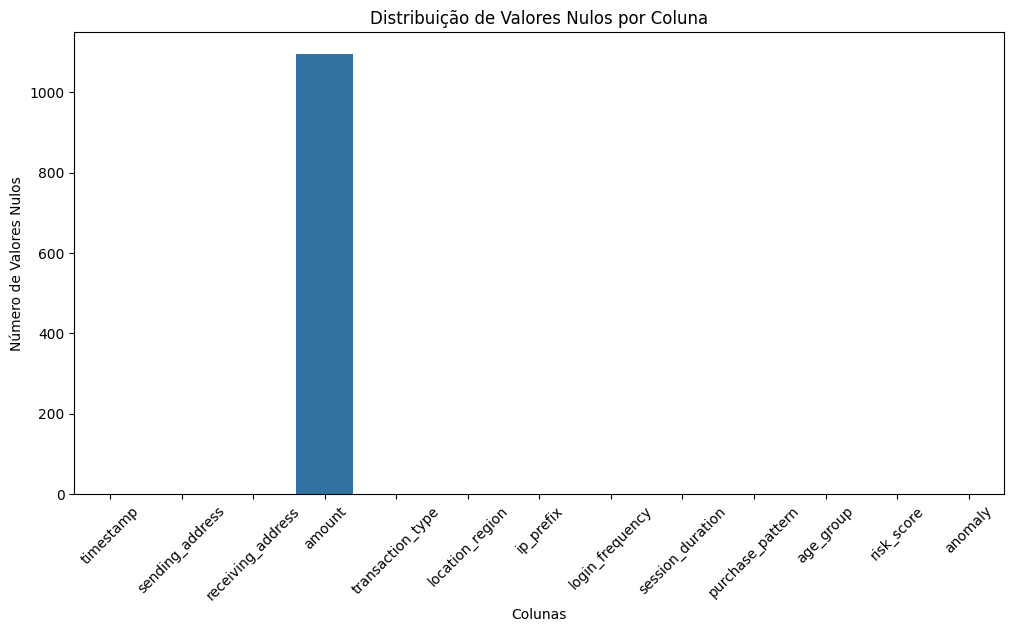

In [77]:
# Coletar o total de erros (valores nulos) em uma lista
total_erros_list = null_counts.select([f.sum(f.col(c)).alias(c) for c in null_counts.columns]).collect()
total_erros_dict = total_erros_list[0].asDict()

# Converter os valores para inteiros e preparar para plotagem
total_erros = {col: int(value) for col, value in total_erros_dict.items()}

# Criar gráfico da distribuição de valores nulos por coluna
plt.figure(figsize=(12, 6))
sns.barplot(x=list(total_erros.keys()), y=list(total_erros.values()))
plt.title('Distribuição de Valores Nulos por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Número de Valores Nulos')
plt.xticks(rotation=45)
plt.show()

#### 4.2 - Percentual de Conformidade

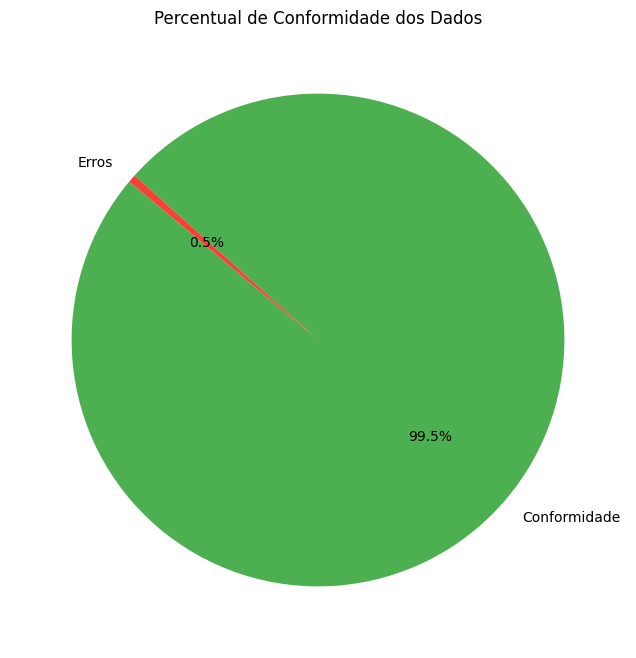

In [79]:
# Verificar valores de 'amount' que são negativos ou zero
valores_incorretos = df_fraud_credit.filter(f.col("amount") <= 0).count()

# Calcular o percentual de conformidade
percentual_conformidade = ((total_registros - total_erros.get('amount', 0)) / total_registros) * 100
percentual_erros = 100 - percentual_conformidade

# Dados para o gráfico de pizza
labels = ['Conformidade', 'Erros']
sizes = [percentual_conformidade, percentual_erros]
colors = ['#4CAF50', '#F44336']  # Verde para conformidade, vermelho para erros

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentual de Conformidade dos Dados')
plt.show()


#### 4.3 - Distribuição dos Valores em "amount"

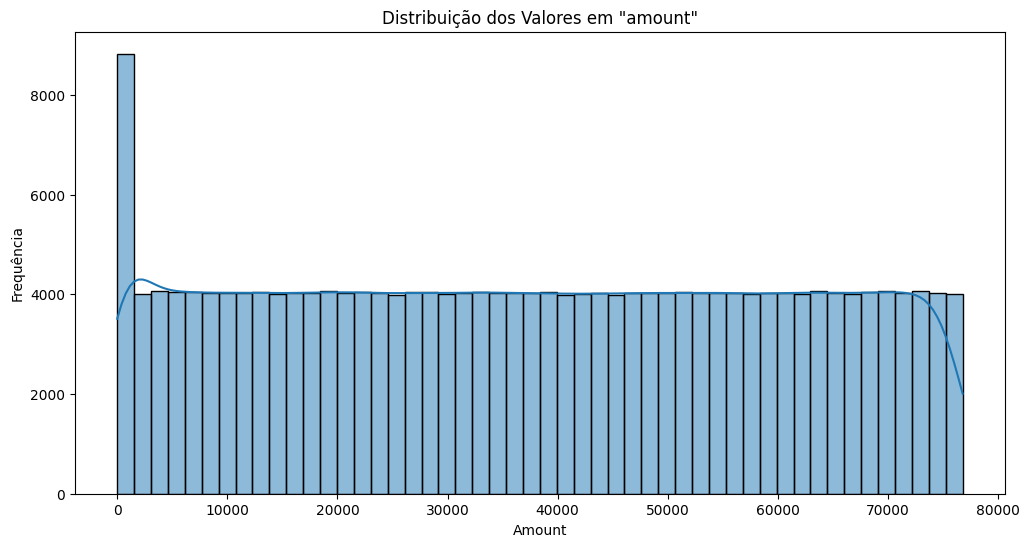

In [80]:
# Criar gráfico da distribuição dos valores em 'amount'
amount_values = df_fraud_credit.filter(f.col("amount").isNotNull()).select("amount").toPandas()

# Converter 'amount' para numérico, forçando erros a NaN
amount_values["amount"] = pd.to_numeric(amount_values["amount"], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(amount_values["amount"].dropna(), bins=50, kde=True)
plt.title('Distribuição dos Valores em "amount"')
plt.xlabel('Amount')
plt.ylabel('Frequência')
plt.show()

## **5 - Conteinerização**

Para garantir a portabilidade e a fácil execução da solução em diversos ambientes, é recomendável contêinerizar o processamento de dados. O arquivo CSV, que serve como a entrada para a solução, pode ser armazenado em um data lake, seja nos Azure Blob Storage, Google Cloud Storage (GCS) ou Amazon S3 (na AWS). A arquitetura de data lake oferece uma maneira segura e escalável de armazenar dados brutos e processados.

## **6 - Orquestração**

* **1 - Monitoramento de Eventos**:

 Configurar uma pasta no data lake (Azure Blob Storage, Google Cloud Storage ou Amazon S3) para armazenar o arquivo CSV e quaisquer atualizações futuras.
Utilizar um serviço de monitoramento de eventos, como Azure Data Factory, Google Cloud Functions ou AWS Lambda, para detectar quando um novo arquivo é carregado na pasta predefinida.



* **2 - Acionamento Automático**:

 Quando um novo arquivo é detectado, o serviço de monitoramento aciona automaticamente o processo de carga.
Isso pode ser realizado chamando este notebook ou um outro pipeline específico para processar o arquivo CSV, realizar a limpeza dos dados e atualizar as tabelas conforme necessário.

* **3 - Logs e Alertas**:

  Configurar logs e alertas para acompanhar o status do processo de carga e notificar a equipe de operações sobre possíveis falhas ou problemas com os dados.


* **4 - Benefícios da Abordagem**:

 * **Eficiência**: Reduz a necessidade de intervenção manual e garante que os dados sejam processados automaticamente conforme chegam.
 * **Escalabilidade**: Facilita a adição de novos arquivos e atualizações sem necessidade de reconfiguração manual.
 * **Confiabilidade**: A automação e monitoramento garantem que o processo de carga seja executado de forma consistente e confiável.
Essa abordagem garante que a pipeline de dados esteja sempre atualizada e pronta para processar novos dados de forma eficiente e automatizada.